In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os

from neuropacks import PVC11
from noise_correlations import (analysis,
                                discriminability,
                                null_models,
                                utils,
                                plot)
from pratplot import colorbar as pcb

%matplotlib inline

In [2]:
# Load PVC11 dataset
base_path = '/Volumes/pss/data/pvc11/data/spikes_gratings'
data_path = os.path.join(base_path, 'data_monkey1_gratings.mat')
pack = PVC11(data_path)

In [3]:
# Get response matrix for PVC11 dataset, and stimuli
X = pack.get_response_matrix(transform=None)
stimuli = pack.get_design_matrix(form='angle')
# Delete neurons that don't response at all to a stimulus
X = np.delete(X, utils.get_nonresponsive_for_stim(X, stimuli), axis=1)
# Get units that are overall "responsive"
responsive_units = utils.get_responsive_units(
    X, stimuli, aggregator=np.mean,
    peak_response=10.)
X = X[:, responsive_units]

In [4]:
# Random state
rng = np.random.RandomState(2332)

In [7]:
dims = np.array([2, 5, 10])
n_dims = dims.size
n_dimlets = 20
n_repeats = 1000
v_s_lfis = np.zeros((n_dims, n_dimlets * pack.n_stimuli, n_repeats))
v_s_sdkls = np.zeros_like(v_s_lfis)
v_r_lfis = np.zeros_like(v_s_lfis)
v_r_sdkls = np.zeros_like(v_s_lfis)
v_lfis = np.zeros((n_dims, n_dimlets * pack.n_stimuli))
v_sdkls = np.zeros_like(v_lfis)
units = {idx: np.zeros((n_dimlets * pack.n_stimuli, dim)) for idx, dim in enumerate(dims)}
stims = np.zeros((n_dims, n_dimlets * pack.n_stimuli, 2))

In [8]:
# Calculate null measures across dims
for idx, dim in enumerate(dims):
    print(idx)
    v_s_lfis[idx], v_s_sdkls[idx], v_r_lfis[idx], v_r_sdkls[idx], \
    v_lfis[idx], v_sdkls[idx], units[idx], stims[idx] = \
        analysis.calculate_null_measures(
            X, stimuli,
            n_dim=dim,
            n_dimlets=n_dimlets,
            rng=rng,
            n_repeats=n_repeats,
            circular_stim=True)

0
1
2


In [43]:
# Calculate percentiles
p_r_lfi = 100 * np.mean(v_lfis[..., np.newaxis] > v_r_lfis, axis=2)
p_r_sdkl = 100 * np.mean(v_sdkls[..., np.newaxis] > v_r_sdkls, axis=2)

In [38]:
# Calculate angles 
angles0 = np.zeros((n_dims, n_dimlets * pack.n_stimuli))
angles1 = np.zeros_like(angles0)

for ii, dim in enumerate(dims):
    for jj, stim in enumerate(stims[ii]):
        stim0_idx = np.argwhere(stimuli == stim[0]).ravel()
        stim1_idx = np.argwhere(stimuli == stim[1]).ravel()
        X0 = X[stim0_idx][:, units[ii][jj]]
        X1 = X[stim1_idx][:, units[ii][jj]]
        mu0, cov0 = utils.mean_cov(X0)
        mu1, cov1 = utils.mean_cov(X1)

        _, eigs0 = np.linalg.eigh(cov0)
        _, eigs1 = np.linalg.eigh(cov1)

        angles0[ii, jj] = utils.compute_angle(eigs0[:, -1], mu0 - mu1)
        angles1[ii, jj] = utils.compute_angle(eigs1[:, -1], mu0 - mu1)

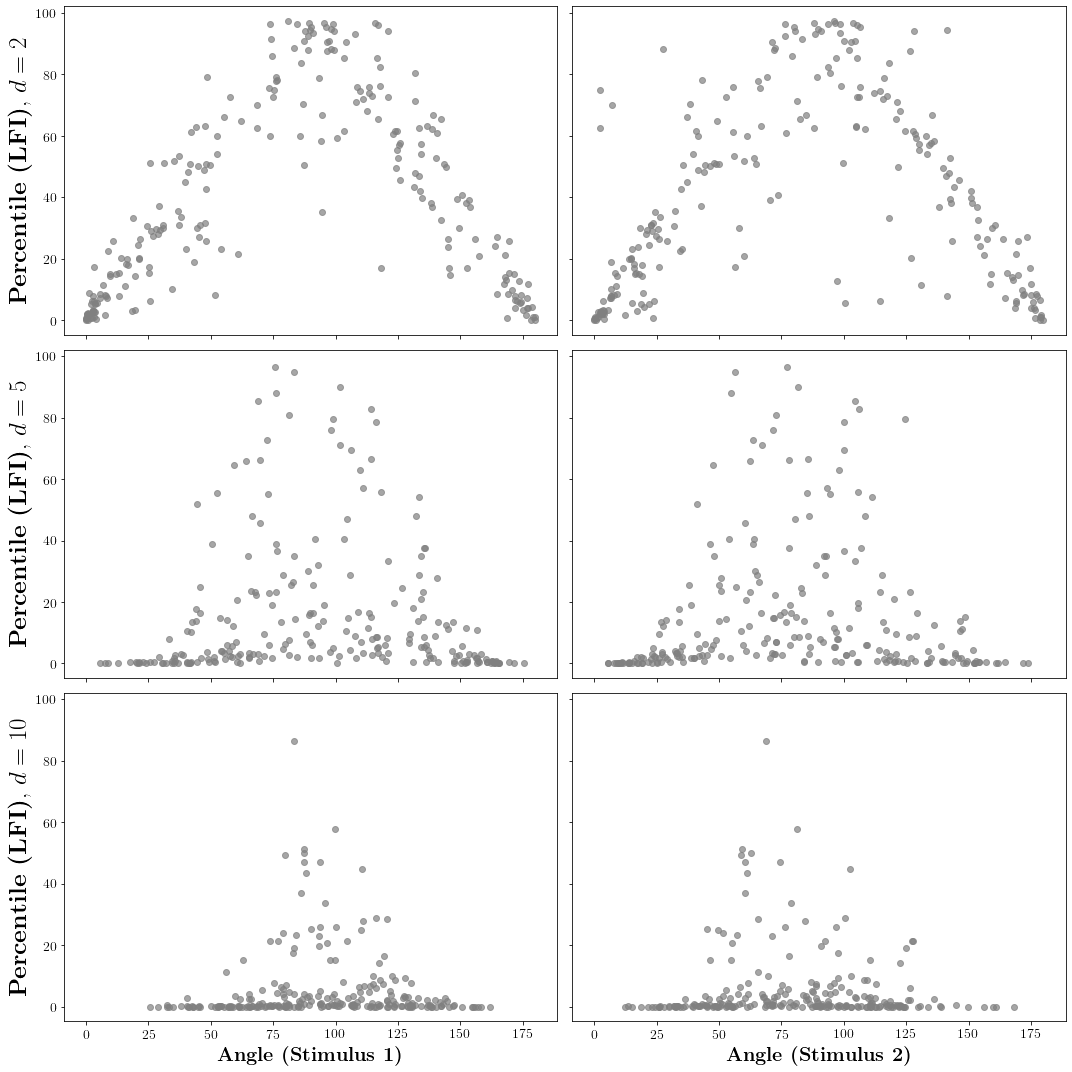

In [52]:
fig, axes = plt.subplots(3, 2, figsize=(15, 15), sharey=True, sharex=True)

for idx, dim in enumerate(dims):
    axes[idx, 0].scatter(angles0[idx], p_r_lfi[idx], color='gray', alpha=0.70)
    axes[idx, 1].scatter(angles1[idx], p_r_lfi[idx], color='gray', alpha=0.70)

axes[-1, 0].set_xlabel(r'\textbf{Angle (Stimulus 1)}', fontsize=20)
axes[-1, 1].set_xlabel(r'\textbf{Angle (Stimulus 2)}', fontsize=20)

for idx, ax in enumerate(axes[:, 0]):
    ax.set_ylabel(r'\textbf{Percentile (LFI)}, $d=%s$' % dims[idx])

for ax in axes.ravel():
    ax.tick_params(labelsize=14)

plt.tight_layout()

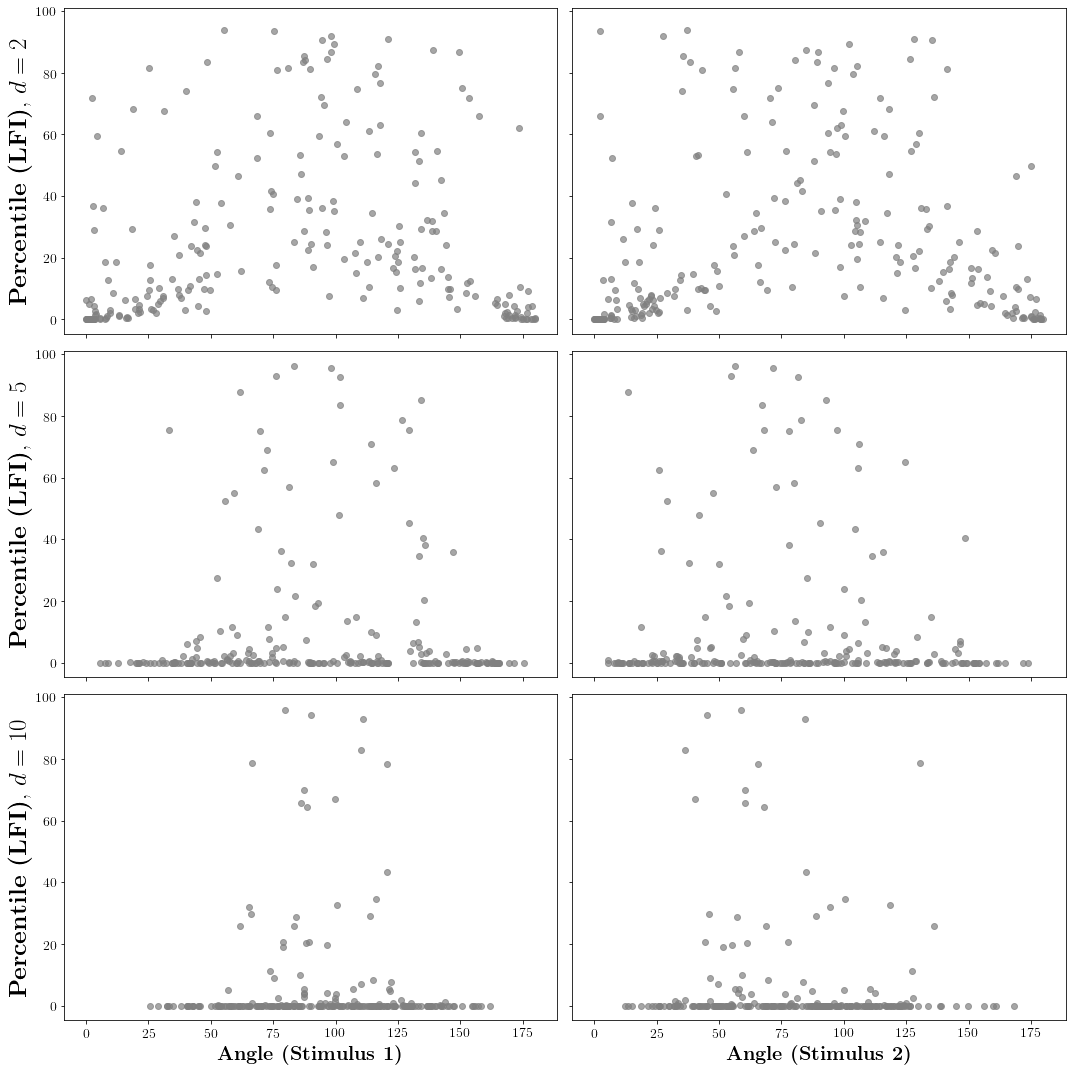

In [53]:
fig, axes = plt.subplots(3, 2, figsize=(15, 15), sharey=True, sharex=True)

for idx, dim in enumerate(dims):
    axes[idx, 0].scatter(angles0[idx], p_r_sdkl[idx], color='gray', alpha=0.70)
    axes[idx, 1].scatter(angles1[idx], p_r_sdkl[idx], color='gray', alpha=0.70)

axes[-1, 0].set_xlabel(r'\textbf{Angle (Stimulus 1)}', fontsize=20)
axes[-1, 1].set_xlabel(r'\textbf{Angle (Stimulus 2)}', fontsize=20)

for idx, ax in enumerate(axes[:, 0]):
    ax.set_ylabel(r'\textbf{Percentile (LFI)}, $d=%s$' % dims[idx])

for ax in axes.ravel():
    ax.tick_params(labelsize=14)

plt.tight_layout()

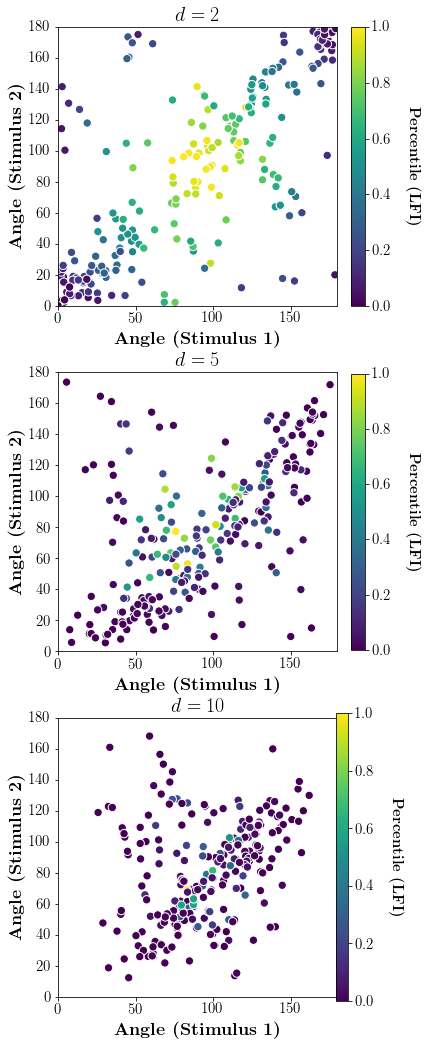

In [63]:
fig, axes = plt.subplots(3, 1, figsize=(5, 18))

for idx, dim in enumerate(dims):
    ax = axes[idx]
    
    ax.scatter(
        angles0[idx], angles1[idx],
        color=pcb.scale_values_to_cmap(p_r_lfi[idx], 'viridis'),
        s=70,
        edgecolor='white'
    )
    ax.set_aspect('equal')

    cb, cax = pcb.append_colorbar_to_axis(
        ax=ax,
        mappable=matplotlib.cm.ScalarMappable(
            norm=matplotlib.colors.Normalize(vmin=0, vmax=1.),
            cmap='viridis'
    ))

    ax.tick_params(labelsize=15)
    ax.set_xlim([0, 180])
    ax.set_ylim([0, 180])
    ax.set_xlabel(r'\textbf{Angle (Stimulus 1)}', fontsize=18)
    ax.set_ylabel(r'\textbf{Angle (Stimulus 2)}', fontsize=18)
    ax.set_title(f'$d={dim}$', fontsize=20)
    cax.tick_params(labelsize=15)
    cb.set_label(r'\textbf{Percentile (LFI)}', rotation=270, labelpad=30, fontsize=15)

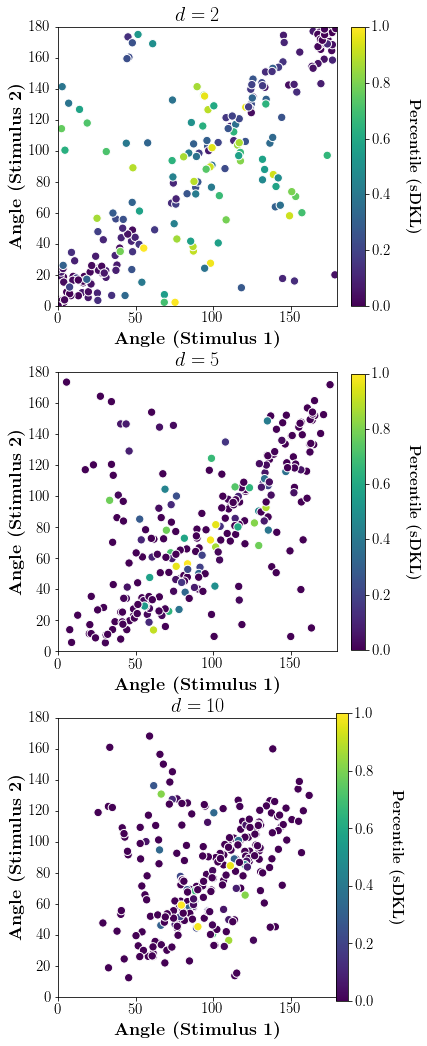

In [65]:
fig, axes = plt.subplots(3, 1, figsize=(5, 18))

for idx, dim in enumerate(dims):
    ax = axes[idx]
    
    ax.scatter(
        angles0[idx], angles1[idx],
        color=pcb.scale_values_to_cmap(p_r_sdkl[idx], 'viridis'),
        s=70,
        edgecolor='white'
    )
    ax.set_aspect('equal')

    cb, cax = pcb.append_colorbar_to_axis(
        ax=ax,
        mappable=matplotlib.cm.ScalarMappable(
            norm=matplotlib.colors.Normalize(vmin=0, vmax=1.),
            cmap='viridis'
    ))

    ax.tick_params(labelsize=15)
    ax.set_xlim([0, 180])
    ax.set_ylim([0, 180])
    ax.set_xlabel(r'\textbf{Angle (Stimulus 1)}', fontsize=18)
    ax.set_ylabel(r'\textbf{Angle (Stimulus 2)}', fontsize=18)
    ax.set_title(f'$d={dim}$', fontsize=20)
    cax.tick_params(labelsize=15)
    cb.set_label(r'\textbf{Percentile (sDKL)}', rotation=270, labelpad=30, fontsize=15)

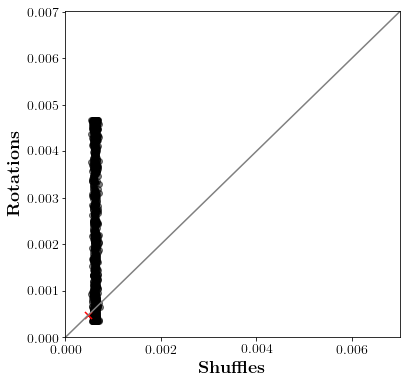

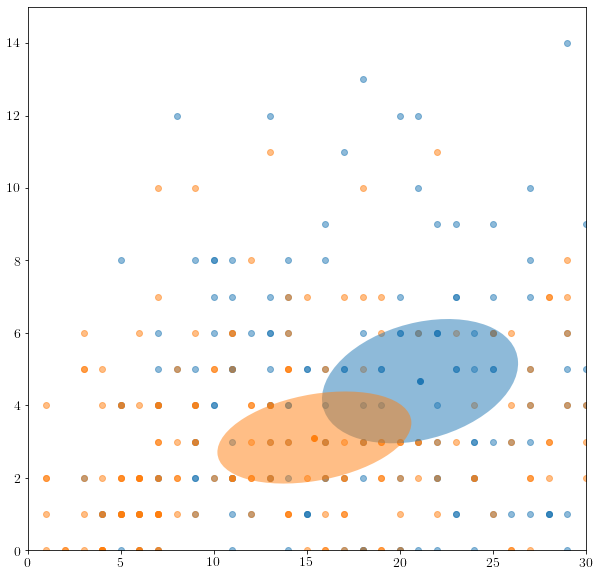

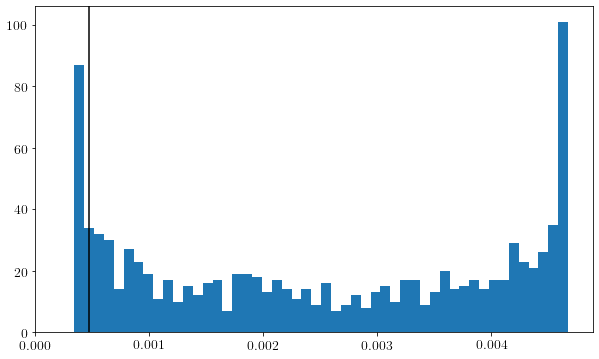

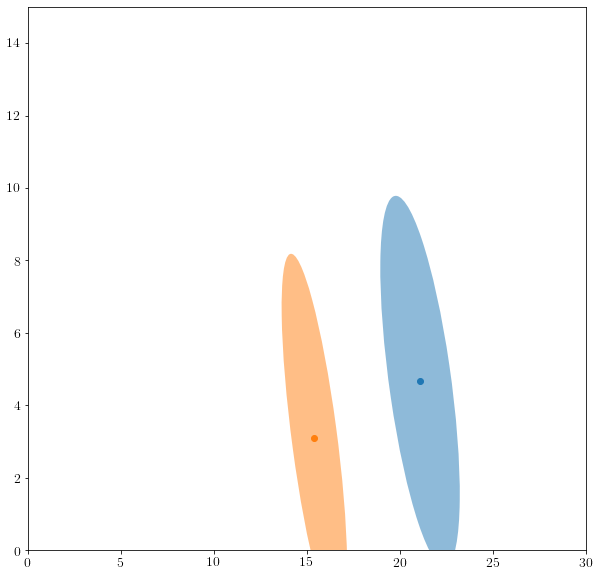

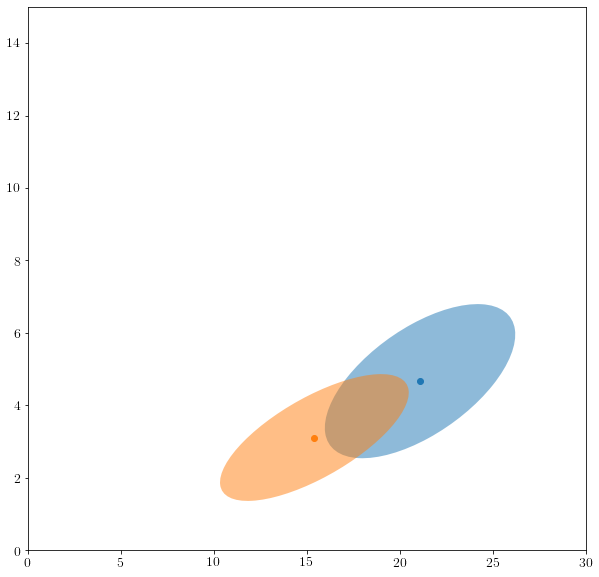

In [24]:
rot_idx = 22

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.scatter(
    v_s_lfi[rot_idx],
    v_r_lfi[rot_idx],
    color='black',
    alpha=0.5)
ax.scatter(
    v_lfi[rot_idx],
    v_lfi[rot_idx],
    color='red',
    marker='x',
    s=50)
max_val = np.max((v_s_lfi[rot_idx], v_r_lfi[rot_idx]))
ax.set_xlim([0, 1.5 * max_val])
ax.set_ylim([0, 1.5 * max_val])
ax.set_xlabel(r'\textbf{Shuffles}', fontsize=18)
ax.set_ylabel(r'\textbf{Rotations}', fontsize=18)
ax.plot(ax.get_xlim(), ax.get_ylim(), color='gray')
ax.tick_params(labelsize=14)

plt.show()

# second plot
stim0_idx = np.argwhere(stimuli == stims[rot_idx][0]).ravel()
stim1_idx = np.argwhere(stimuli == stims[rot_idx][1]).ravel()
X0 = X[stim0_idx][:, units[rot_idx]]
X1 = X[stim1_idx][:, units[rot_idx]]

mu0, cov0 = utils.mean_cov(X0)
mu1, cov1 = utils.mean_cov(X1)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plot.plot_ellipses(mu0, cov0, mu1, cov1, faxes=(fig, ax))
ax.set_xlim([0, 30])
ax.set_ylim([0, 15])
ax.scatter(X0[:, 0], X0[:, 1], color=u'#1f77b4', alpha=0.5)
ax.scatter(X1[:, 0], X1[:, 1], color=u'#ff7f0e', alpha=0.5)
ax.tick_params(labelsize=14)

plt.show()

# third plot
observed = discriminability.lfi(
    mu0, cov0, mu1, cov1,
    dtheta=np.abs(stims[rot_idx][1] - stims[rot_idx][0])
)
rotations = np.zeros(1000)
cov0s = np.zeros((2, 2, 1000))
cov1s = np.zeros((2, 2, 1000))

for idx in range(rotations.size):
    (mu0r, mu1r), (cov0r, cov1r) = null_models.random_rotation([mu0, mu1], [cov0, cov1], rng=rng)
    rotations[idx] = discriminability.lfi(
        mu0r, cov0r, mu1r, cov1r,
        dtheta=np.abs(stims[rot_idx][1] - stims[rot_idx][0])
    )
    cov0s[:, :, idx] = cov0r
    cov1s[:, :, idx] = cov1r
    
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.hist(rotations, bins=50)
ax.set_xlim(left=0)
ax.axvline(observed, color='black')
ax.tick_params(labelsize=14)

plt.show()

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
max_idx = np.argmax(rotations)
plot.plot_ellipses(mu0, cov0s[:, :, max_idx], mu1, cov1s[:, :, max_idx], faxes=(fig, ax))
ax.set_xlim([0, 30])
ax.set_ylim([0, 15])
ax.tick_params(labelsize=14)

plt.show()

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
min_idx = np.argmin(rotations)
plot.plot_ellipses(mu0, cov0s[:, :, min_idx], mu1, cov1s[:, :, min_idx], faxes=(fig, ax))
ax.set_xlim([0, 30])
ax.set_ylim([0, 15])
ax.tick_params(labelsize=14)

plt.show()